<img src="https://www.ucenfotec.ai/images/logo.png" />

In [10]:
import sys
import os
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img

## Cargar Datos

In [2]:
# retirar comentario para descargar datos (810Mb)
#!wget -c http://files.fast.ai/files/dogscats.zip

--2020-04-20 02:12:58--  http://files.fast.ai/files/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 861515103 (822M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 821.60M  24.8MB/s    in 89s     

2020-04-20 02:14:28 (9.19 MB/s) - ‘dogscats.zip’ saved [861515103/861515103]



In [4]:
# retirar comentario para hacer unzip (probado en linux)
#!unzip dogscats.zip

In [19]:
tipos = []

gatos = os.listdir("dogscats/train/cats")
y_gatos = np.array(['gato' for _ in range(len(gatos))])
perros = os.listdir("dogscats/train/dogs")
y_perros = np.array(['perro' for _ in range(len(perros))])
        
gatos_df = pd.DataFrame({'archivo':gatos, 'tipo': y_gatos})
gatos_df['archivo'] = "cats/" + gatos_df['archivo']

perros_df = pd.DataFrame({'archivo':perros, 'tipo': y_perros})
perros_df['archivo'] = "dogs/" + perros_df['archivo']

data = pd.DataFrame(columns=['archivo','tipo'])
data = data.append(perros_df)
data = data.append(gatos_df)

data.head()       

,archivo,tipo
0,dogs/dog.3671.jpg,perro
1,dogs/dog.8167.jpg,perro
2,dogs/dog.2122.jpg,perro
3,dogs/dog.11646.jpg,perro
4,dogs/dog.962.jpg,perro


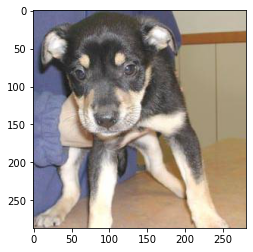

In [25]:
# ejemplo de una imagen aleatoria del dataset

imagen = load_img("dogscats/train/dogs/dog.11646.jpg")
plt.imshow(imagen) # zaguatico <3 

In [37]:
# vamos a pomer 80% de las imagenes en el set de entrenamiento y
# 20% en el set de pruebas
from sklearn.model_selection import train_test_split
entrenamiento, pruebas = train_test_split(data, test_size=0.2)


# configuracion de entrenamiento
entrenamiento_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# generador
generador_entrenamiento = entrenamiento_datagen.flow_from_dataframe(
    entrenamiento,
    "dogscats/train",
    x_col="archivo", # nombre de imagenes
    y_col="tipo", # nombre de las clases de cada imagen
    target_size=(128,128),
    class_mode='categorical',
    batch_size = 64
)

# configuacion de pruebas (test set)
pruebas_datagen = ImageDataGenerator(rescale=1./255)

# generador pruebas
generator_pruebas = pruebas_datagen.flow_from_dataframe(
    pruebas,
    "dogscats/train",
    x_col="archivo", # nombre de imagenes
    y_col="tipo", # nombre de las clases de cada imagen
    target_size=(128,128),
    class_mode='categorical',
    batch_size = 64)

Found 18399 validated image filenames belonging to 2 classes.
Found 4601 validated image filenames belonging to 2 classes.


## Arquitectura Convolucional

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

modelo = Sequential()

modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

modelo.add(Conv2D(128, (3, 3), activation='relu'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

modelo.add(Flatten())
modelo.add(Dense(512, activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Dropout(0.5))
modelo.add(Dense(2, activation='softmax')) # clasificacion binaria

modelo.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

modelo.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)       

In [39]:
## Empezar el entrenamiento 

epocs = 50

# entrenar 50 veces el modelo.
historia = modelo.fit_generator(
    generador_entrenamiento, 
    epochs = epocs, 
    verbose = 1,
    validation_data=generator_pruebas
)

# salvar el modelo
modelo.save("perros-gatos.h5")

Epoch 1/50
288/288 [==============================] - 110s 381ms/step - loss: 0.8701 - accuracy: 0.5974 - val_loss: 0.6942 - val_accuracy: 0.5353
Epoch 2/50
288/288 [==============================] - 106s 366ms/step - loss: 0.6199 - accuracy: 0.6680 - val_loss: 0.7497 - val_accuracy: 0.6194
Epoch 3/50
288/288 [==============================] - 106s 368ms/step - loss: 0.5571 - accuracy: 0.7157 - val_loss: 0.4487 - val_accuracy: 0.7361
Epoch 4/50
288/288 [==============================] - 106s 367ms/step - loss: 0.5267 - accuracy: 0.7399 - val_loss: 0.6260 - val_accuracy: 0.6979
Epoch 5/50
288/288 [==============================] - 106s 367ms/step - loss: 0.4935 - accuracy: 0.7603 - val_loss: 0.6565 - val_accuracy: 0.7740
Epoch 6/50
288/288 [==============================] - 105s 366ms/step - loss: 0.4734 - accuracy: 0.7773 - val_loss: 0.5704 - val_accuracy: 0.7209
Epoch 7/50
288/288 [==============================] - 105s 366ms/step - loss: 0.4504 - accuracy: 0.7899 - val_loss: 0.3363 -

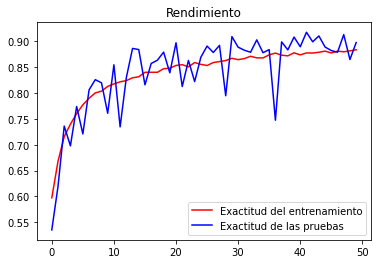

<Figure size 432x288 with 0 Axes>

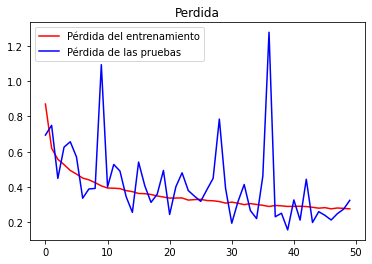

<Figure size 432x288 with 0 Axes>

In [42]:
# Entre mas cercano a 1, mejor es la capacidad predictiva.
entrenamiento_acc = historia.history['accuracy']
entrenamiento_perdida = historia.history['loss']

pruebas_acc = historia.history['val_accuracy']
pruebas_perdida = historia.history['val_loss']

epochs = range(len(entrenamiento_acc))

plt.plot(epochs, entrenamiento_acc, 'r', label='Exactitud del entrenamiento')
plt.plot(epochs, pruebas_acc, 'b', label='Exactitud de las pruebas')
plt.title('Rendimiento')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, entrenamiento_perdida, 'r', label='Pérdida del entrenamiento')
plt.plot(epochs, pruebas_perdida, 'b', label='Pérdida de las pruebas')
plt.title('Perdida')
plt.legend(loc=0)
plt.figure()

plt.show()

## Predicciones

In [46]:
from keras.preprocessing import image
import tensorflow as tf
import numpy as np

modelo = tf.keras.models.load_model('perros-gatos.h5')

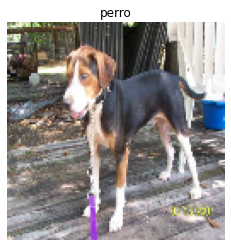

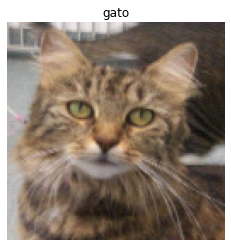

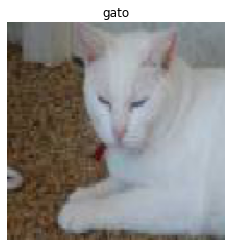

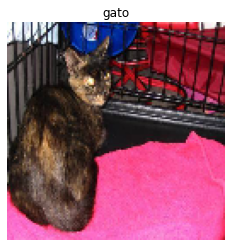

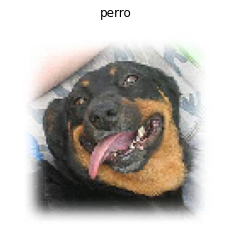

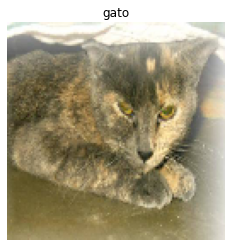

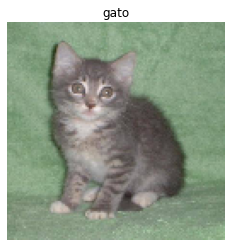

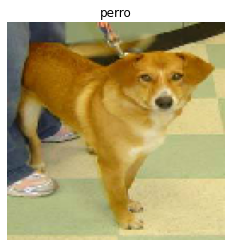

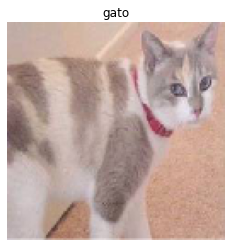

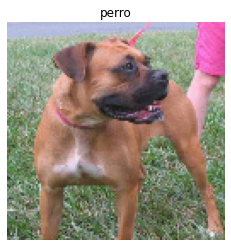

In [99]:
clases = ['gato', 'perro']
animales = os.listdir("dogscats/test1")[:10]
for animal in animales:
    # se carga y normaliza la imagen
    img = image.load_img("dogscats/test1/" + animal, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    # se realiza la prediccion
    y_prima = modelo.predict(x, batch_size=1)
    indice = np.argmax(y_prima[0].tolist(), axis=0)
    # se imprimen las imagenes
    plt.imshow(img)
    plt.title(clases[indice])
    plt.axis('Off')
    plt.show()